# Shallow Moments with topography (Simple)

## Imports

In [1]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
import jax
from jax import numpy as jnp
import pytest
from types import SimpleNamespace
from sympy import cos, pi, Piecewise, Matrix

from library.fvm.solver import HyperbolicSolver, Settings
from library.fvm.ode import RK1
import library.fvm.reconstruction as recon
import library.fvm.timestepping as timestepping
import library.fvm.flux as flux
import library.fvm.nonconservative_flux as nc_flux
from library.model.boundary_conditions import BoundaryCondition
from library.model.models.basisfunctions import Basisfunction, Legendre_shifted
from library.model.models.basismatrices import Basismatrices
from library.misc.misc import Zstruct

from library.model.models.shallow_moments_topo import ShallowMomentsTopo, ShallowMomentsTopoNumerical
from library.model.models.shallow_moments import ShallowMoments2d

import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
import library.misc.io as io
from library.mesh.mesh import compute_derivatives
from tests.pdesoft import plots_paper
import library.postprocessing.visualization as visu


import library.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing
from library.mesh.mesh import convert_mesh_to_jax
import argparse

2025-08-30 09:25:42.373 | WARNING  | library.fvm.solver:<module>:28 - No module named 'precice'


## Model

In [2]:
level = 1
offset = 1+level
n_fields = 3 + 2 * level
settings = Settings(
    name="SME",
    output=Zstruct(
        directory=f"outputs/topo_{level}", filename="SME", output_snapshots=30
    ),
)

2025-08-30 09:25:44.873 | WARNING  | library.misc.misc:__init__:146 - No 'clean_directory' attribute found in output Zstruct. Default: False


In [ ]:
inflow_dict = { 
    0: lambda t, x, dx, q, qaux, p, n: q[0],
    1: lambda t, x, dx, q, qaux, p, n: Piecewise((0.1, t < 0.2),(q[1], True)),
    2: lambda t, x, dx, q, qaux, p, n: Piecewise((-0.3, t < 0.2),(-q[2], True)),
                }
inflow_dict.update({2+i: lambda t, x, dx, q, qaux, p, n: 0.0 for i in range(1, level+1)})
inflow_dict.update({2+offset+i: lambda t, x, dx, q, qaux, p, n: 0.0 for i in range(level+1)})

bcs = BC.BoundaryConditions(
    [
        BC.Lambda(physical_tag="inflow", prescribe_fields=inflow_dict),
        BC.Wall(physical_tag="wall", momentum_field_indices=[[2+i, 2+offset+i] for i in range(level+1)]),
    ]
)

def custom_ic(x):
    Q = np.zeros(4 + 2 * level, dtype=float)
    Q[0] = x[0] * (0.01)
    Q[1] = np.where(x[0] < 0.35, 0.01, 0.)
    return Q

# def custom_ic_aux(x):
#     Q = custom_ic(x)
#     h = Q[1]
#     # Qaux = np.zeros(1 + 2 + 2 * level, dtype=float)
#     Qaux = np.zeros(1, dtype=float)
#     Qaux[0] = np.where(h > 0, 1/h, 0.0)
#     return Qaux

ic = IC.UserFunction(custom_ic)
# ic_aux = IC.UserFunction(custom_ic_aux)

class MyModel(ShallowMomentsTopoNumerical):
    def source(self):
        out = Matrix([0 for i in range(self.n_variables)])
        out += self.newtonian()
        out += self.slip_mod()
        return self.substitute_precomputed_denominator(out, self.variables[1], self.aux_variables.hinv)
        

model = MyModel(
    level=level,
    boundary_conditions=bcs,
    initial_conditions=ic,
    # aux_initial_conditions=ic_aux,
    parameters=Zstruct(nu=0.000001, lamda=1/1000., rho=1000, c_slipmod=1/30),
    aux_variables = ['hinv'] + [f'dalpha_{i}_dx' for i in range(level+1)] + [f'dbeta_{i}_dy' for i in range(level+1)],
    # aux_variables = ['hinv'],
    
)

refmodel = ShallowMomentsTopo(
    level=level,
    boundary_conditions=bcs,
    initial_conditions=ic,
    parameters=Zstruct(nu=0.000001, lamda=1/1000., rho=1000, c_slipmod=1/30),
    aux_variables = ['hinv']
)

main_dir = os.getenv("ZOOMY_DIR")
mesh = petscMesh.Mesh.from_gmsh(
    os.path.join(main_dir, "meshes/channel_junction/mesh_2d_coarse.msh")
    # os.path.join(main_dir, "meshes/channel_junction/mesh_2d_fine.msh")
)

mesh = convert_mesh_to_jax(mesh)
class SMESolver(HyperbolicSolver):
    def update_q(self, Q, Qaux, mesh, model, parameters):
        h = Q[1]
        # h = jnp.where(h > 0, h, 0.0)
        Q = Q.at[1:].set(jnp.where(h > 0, Q[1:], jnp.zeros_like(Q[1:])))
        # Q = Q.at[1].set(h)
        return Q
    
    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):
        level = (model.n_variables-2)//2 -1
        offset = 1+level
        ## h with wet/dry fix
        h = Q[1]
        # hinv = 1/h

        ### This does not work for some reason
        # h = jnp.where(h > 0, h, 0.0)
        # eps = 1e-6
        # denom = jnp.sqrt(h**4 + jnp.where(h**4 > eps, h**4, eps))
        # hinv = (jnp.sqrt(2.0) * h) / denom
        # Qaux = Qaux.at[0].set(hinv)
        
        h = jnp.where(h > 0, h, 0.0)
        eps = 1e-6
        denom = jnp.where(h**2 > eps, h**2, eps)
        hinv = (h) / denom
        Qaux = Qaux.at[0].set(hinv)
        
        idxs = jnp.arange(level+1)

        # derivatives of alpha and beta for 3d interpolation
        # dalphaidx for each i
        dalphaidxs = jax.vmap(
            lambda i: compute_derivatives(Q[2+i] * hinv, mesh,
                                        derivatives_multi_index=[[0, 0]])[:, 0]
        )(idxs)

        # dbetaidy for each i
        dbetaidys = jax.vmap(
            lambda i: compute_derivatives(Q[2+offset+i] * hinv, mesh,
                                        derivatives_multi_index=[[0, 1]])[:, 0]
        )(idxs)

        # scatter results into Qaux
        Qaux = Qaux.at[1:1+level+1].set(dalphaidxs)
        Qaux = Qaux.at[1+offset:1+offset+level+1].set(dbetaidys)
        
        return Qaux
# solver = SMESolver(settings=settings, time_end=0.000035, compute_dt=timestepping.constant(dt =0.0000001))

solver = SMESolver(settings=settings, time_end=5., compute_dt=timestepping.adaptive(CFL=0.45))

In [ ]:
sme = ShallowMoments2d(
    level=level,
    boundary_conditions=bcs,
    initial_conditions=ic,
    parameters=Zstruct(nu=0.000001, lamda=1/1000., rho=1000, c_slipmod=1/30),
)

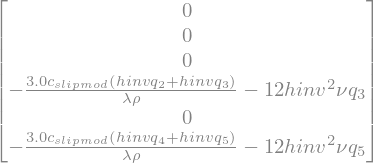

In [ ]:
model.source()

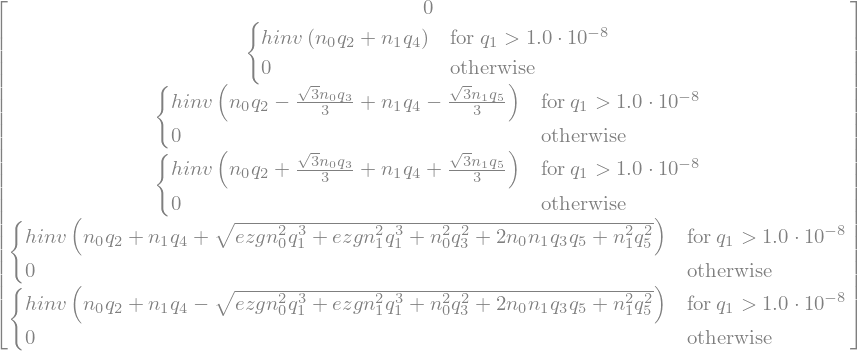

In [ ]:
model.eigenvalues()

## Solve

In [ ]:
Qnew, Qaux = solver.solve(mesh, model)

2025-08-30 09:22:26.021 | INFO     | library.fvm.solver:log_callback_hyperbolic:44 - iteration: 1, time: 0.003386, dt: 0.003386, next write at time: 0.011111
2025-08-30 09:22:26.062 | INFO     | library.fvm.solver:log_callback_hyperbolic:44 - iteration: 2, time: 0.003652, dt: 0.000266, next write at time: 0.022222
2025-08-30 09:22:26.112 | INFO     | library.fvm.solver:log_callback_hyperbolic:44 - iteration: 3, time: 0.003918, dt: 0.000266, next write at time: 0.033333
2025-08-30 09:22:26.154 | INFO     | library.fvm.solver:log_callback_hyperbolic:44 - iteration: 4, time: 0.004184, dt: 0.000266, next write at time: 0.044444
2025-08-30 09:22:26.205 | INFO     | library.fvm.solver:log_callback_hyperbolic:44 - iteration: 5, time: 0.004450, dt: 0.000266, next write at time: 0.055556
2025-08-30 09:22:26.247 | INFO     | library.fvm.solver:log_callback_hyperbolic:44 - iteration: 6, time: 0.004715, dt: 0.000266, next write at time: 0.066667
2025-08-30 09:22:26.296 | INFO     | library.fvm.sol

## Visualization

In [ ]:
io.generate_vtk(os.path.join(settings.output.directory, f"{settings.output.filename}.h5"))
# postprocessing.vtk_interpolate_3d(model, settings, Nz=20, filename='out_3d')

In [ ]:
# visu.pyvista_3d(settings.output.directory, scale=1.0)